# PA005 - High Value Customer Identification (Insiders)

# Planejanamento da solução (IoT)

## Input - Entrada
    

1. Problema do negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização

2. Conjunto de dados
    - Vendas de um e-commerce online durante o período de um ano

## Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider |
                10323  | yes/1
                32413  | no/1
                
                
2. Relatório
    1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    2. Quantos clientes farão parte do grupo?
    3. Quais as principais características desses clientes ?
    4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    7. Quais as condições para uma pessoa ser removida do Insiders ?
    8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento: 
        - Alto ticket médio.
        - Alto LTV (life time value).
        - Baixa Recência.
        - Alto basket size.
        - Baixa probabilidade de Churn.
        - Alta previsão de LTV
        - Alta propensão de compra
        
    - Custo:
        - Baixo taxa de devolução
        
    - Experiência 
        - Média alta de avaliação
        
        
2. Quantos clientes farão parte do grupo?
    - Número total de cliente
    - % do grupo de Insiders
    
3. Quais as principais características desses clientes ?
    - Escrever características do cliente:
        Idade
        Localização
    - Escrever características do consumo:
        Atributos da clusterização
        
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort 
    
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo
    
7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser dessimilar ou parecido com uma pessoa do grupo
    
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frente
    - Visita a empresa

# Imports

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import regex as re

import umap.umap_ as umap

#from pandas_profiling import ProfileReport

from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp

#from plotly import express as px

from matplotlib import pyplot as plt

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Helper Functions

In [70]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/alex/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['re']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Load dataset

In [71]:
df_raw = pd.read_csv('datasets/Ecommerce.csv', encoding='unicode_escape')

#drop extra column
df_raw = df_raw.drop( columns= ['Unnamed: 8'], axis = 1 )

# Descrição dos dados

In [72]:
df1 = df_raw.copy()

## Rename Columns

In [73]:
cols_news = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date','unit_price', 'customer_id', 'country']
df1.columns = cols_news

## Data dimensions

In [74]:
df1.shape

(541909, 8)

## Data types

In [75]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Data Check NA

In [76]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Replace NA

In [77]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

#create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange( 19000, 19000+len(df_backup), 1)

#merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

#drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1)

In [78]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## Change dtypes

In [79]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [80]:
#invoice_date
df1['invoice_date'] =pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype(np.int64)

In [81]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## Descriptive Statistics

In [82]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributs

In [83]:
#Central Tendecy - média e mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - desvio, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


**Skew:** mostra a deformação da sua distribuição em relação a normal

    **Skew positiva:** deformação para a esquerda
    
    **Skew negativa:** deformação para a direita
    
**Kurtosis:** mostra o quão os dados estão concentrados.

    Quanto maior a kurtosis mais dados concentrados, ou seja o pico da curva será muito grande
    
    Quanto menor a kurtosis,mais dispersos estão os dados, ou seja, o pico da curva será menor

#### Numerical Attributs - Investigating

1. quantidade negativa (pode ser devolução)
2. preço unitário igual a zero (pode ser promoção?)


### Categorical Attributs

#### Invoice No

In [84]:
#problema: temos letras no meio dos números

df_letter_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]', x))), :]

print('Total number of invoices: {}'.format( len (df_letter_invoice)))
print('Total de número negativos no quantity: {}'.format(len(df_letter_invoice[df_letter_invoice['quantity'] < 0])))

Total number of invoices: 9291
Total de número negativos no quantity: 9288


#### Stock Code

In [85]:
#check stock codes only caracters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [86]:
#delete description

#### Country

In [87]:
df1['country'].value_counts( normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [88]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# Filtragem de variáveis

In [89]:
df2 = df1.copy()

In [90]:
df2[df2['customer_id'] == 16446]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,PANTRY PASTRY BRUSH,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,United Kingdom,16446


In [91]:
#===== Numerical Attribuets =====
#unit price > 0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

#stock code != [POST, D, M, DOT,CRUK]
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]


#description
df2 = df2.drop( columns='description', axis=1)

#country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

#bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

#quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]

# Feature Engineering

In [92]:
df3 = df2.copy()

In [93]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


## Feature Creation

In [94]:
#Ideias de variáveis a serem criadas
    #Quantidade de compras por mês, antes do dia 15 e depois do dia 15
    

In [95]:
#data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country' ], axis=1).drop_duplicates(ignore_index=True)

### Gross Revenue
Faturamento

In [96]:
#Gross Revenue (Faturamento)
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

#monetary (quanto essa pessoa gastou até o momento)
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left')

/home/alex/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Recency Day
Último dia que foi feita uma compra

In [97]:
# Recency - Last day purchase
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### Quantity of  purchased
Quantas compras a pessoa fez

In [98]:
#número de produtos
df_freq = df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename( columns={'invoice_no': 'qtde_invoices'})
df_ref = pd.merge (df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### Quantity of items purchased
A quantidade de itens comprados

In [99]:
#número de produtos
df_freq = df2_purchase.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename( columns={'quantity': 'qtde_items'})
df_ref = pd.merge (df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### Quantity of products purchased

In [100]:
#número de produtos
df_freq = df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename( columns={'stock_code': 'qtde_products'})
df_ref = pd.merge (df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### Average Ticket Value

In [101]:
#avg ticket (ticket médio)
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### Average Recency Days

In [102]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=['False', 'False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: ( x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

#average recency
df_avg_recency_days = df_aux.groupby( 'customer_id').mean().reset_index()

#merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### Frequency Purchase

In [103]:
df_aux = (df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                  .groupby( 'customer_id')
                                                  .agg( max_ = ( 'invoice_date', 'max'),
                                                        min_ = ( 'invoice_date', 'min'),
                                                        days_ = ('invoice_date', lambda x: ((x.max() - x.min() ) .days)+1),
                                                        buy_ = ('invoice_no', 'count') ) ).reset_index()

#frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

#merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### Number of Returns

In [104]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={ 'quantity':'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### Basket Size
Quantidade de itens por cesta (quantity)

In [105]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                          .agg( n_purchase= ('invoice_no', 'nunique'),
                                                                                n_products=( 'quantity', 'sum') ).reset_index())

#calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

#merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### Unique Basket Size
Quantidade de produtos distintos por compra

In [106]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                          .agg( n_purchase= ('invoice_no', 'nunique'),
                                                                                n_products=( 'stock_code', 'count') ).reset_index())

#calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

#merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [107]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,8.735294
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,19.000000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,15.466667
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,1.000000


# EDA (Explory Data Analysis)

In [108]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## Univariate Analysis
Investigar os outliers e tirar as sujeiros do datasets

**Métricas a serem observadas**

1. Clusters Coesos - Separados
2. Métricas

    . Min, Max, Range
    
    . Média e Mediana
    
    . Desvio Padrão e Variância
    
    . Coeficiente de Variação (CV )
    
    . Distribuição
     

In [109]:
#profile = ProfileReport( df4 )
#profile.to_file( 'output_v3.html' )

Quanto maior o valor da kurtosis, maior a ponta do seu gráfico

Skewness - direita - positiva
         - esquerda- negativa

**Notes**
kurtosis - Quanto maior o valor, maior a ponta do seu gráfico

Skewness - direita - positiva - esquerda- negativa

1. Cluster Coesos - Separados
2. Métricas
    - min, max, range (dispersão)
    - média e mediana
    - desvio padrão e variância
    - coeficiente de variação (CV)
    - Distribuição

### Análise de outliers da variáveis

#### Gross Revenue

In [110]:
#os outliers presentes no gross revenue fazem sentido para o projeto de clusterização

#### Avg Ticket

In [111]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


In [112]:
df3[df3['customer_id'] == 16446]
#ele comprou 81 mil itens e devolveu todos eles, vale a pena manter esse customer no dataset?
#vamos remover esse usuario do dataset

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


#### Qtde items

In [113]:
df4[df4['qtde_items'] == 196844]

#é um cliente incomum, mas parece ser real

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.20339,288.0,2733.944444,28.611111


#### Frequency

In [114]:
df4[df4['customer_id'] == 17850]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.5,17.0,40.0,50.970588,8.735294


#### Avg basket Size

In [115]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


## Bivariate Analysis
Verificar a variabilidade das variáveis para definir a variável resposta

In [116]:
#sns.pairplot(df4)

In [117]:
#frequencia não varia, então provavelmente será removida
#avg ticket não varia

## Estudo do espaço

In [118]:
#df43 = df4.drop(columns=['customer_id'], axis=1).copy()
cols_select = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']

df43 = df4[cols_select].copy()

In [119]:
from sklearn import preprocessing as pp
from sklearn import decomposition as dd

In [120]:
mm = pp.MinMaxScaler()

df43['gross_revenue']          = mm.fit_transform( df43[['gross_revenue']])   
df43['recency_days']           = mm.fit_transform( df43[['recency_days']])
#df43['qtde_invoices']          = mm.fit_transform( df43[['qtde_invoices']])
#df43['qtde_items']             = mm.fit_transform( df43[['qtde_items']])
df43['qtde_products']          = mm.fit_transform( df43[['qtde_products']])
#df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']])
#df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']])
df43['frequency']              = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']])
#df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']])
#df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']])

In [121]:
df43.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,17850,0.019292,0.997319,0.037774,1.000000,0.004438
1,13047,0.011559,0.150134,0.021695,0.001345,0.003883
2,12583,0.024000,0.005362,0.029479,0.002052,0.005547
3,13748,0.003375,0.254692,0.003446,0.000734,0.000000
4,15100,0.003116,0.892761,0.000255,0.003985,0.002441


### PCA

In [122]:
X = df43.copy()

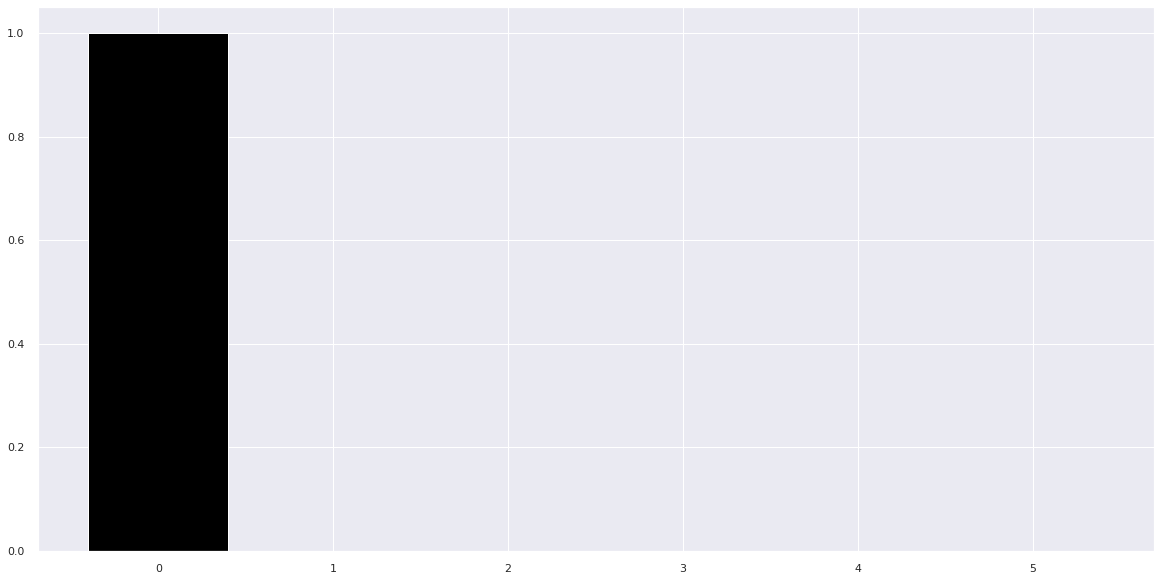

In [123]:
pca = dd.PCA( n_components=X.shape[1])
principal_components = pca.fit_transform( X )

#plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black')

#pca component
df_pca = pd.DataFrame( principal_components )


#Quais são os componentes principais com a maior variação de dados?

In [124]:
df_pca.head()

,0,1,2,3,4,5
0,2579.622979,0.856733,0.078571,-0.052547,-0.045383,0.960655
1,-2223.377022,-0.022794,0.003764,-0.003840,-0.001722,-0.004225
2,-2687.377022,-0.167898,0.012954,-0.004314,0.002124,0.001334
3,-1522.377022,0.082413,-0.010429,0.002939,0.003822,-0.007664
4,-170.377022,0.719939,0.009946,-0.003442,0.003301,-0.027095


<AxesSubplot:xlabel='0', ylabel='1'>

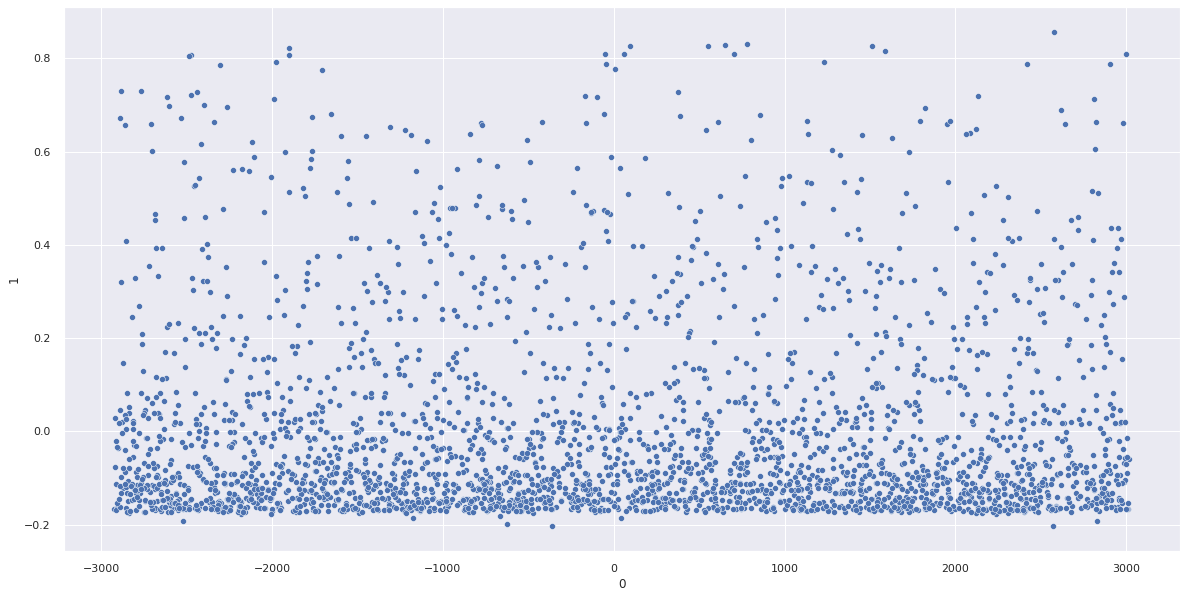

In [125]:
sns.scatterplot( x=0, y=1, data=df_pca)

### UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

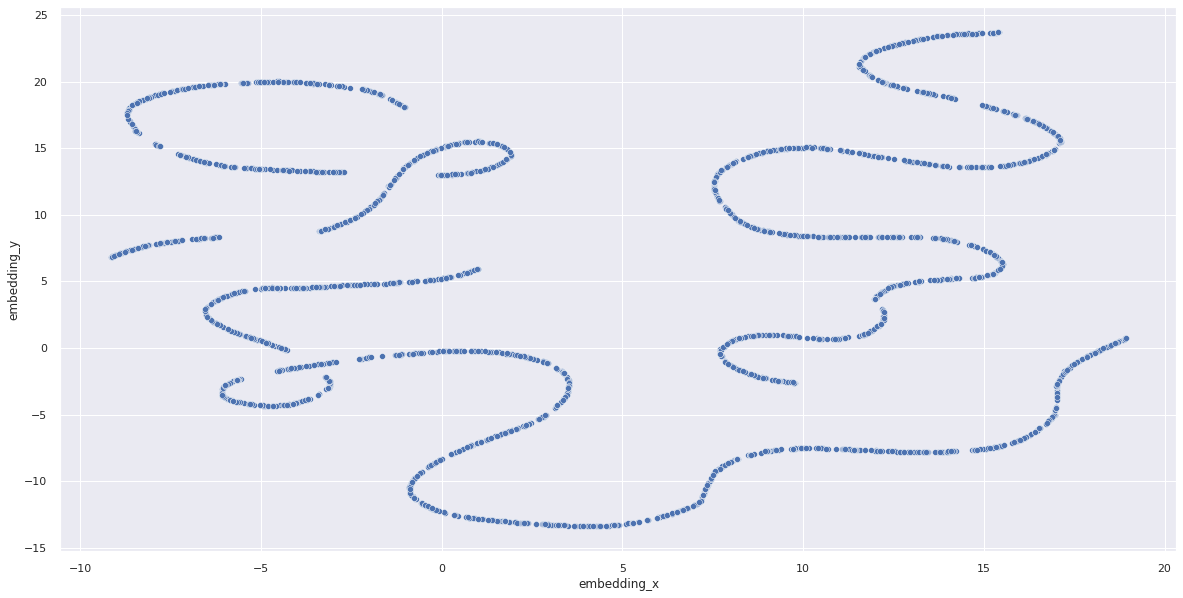

In [126]:
reducer = umap.UMAP( random_state=42)
embedding = reducer.fit_transform( X )

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

### t-SNE

In [127]:
from sklearn.manifold import TSNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

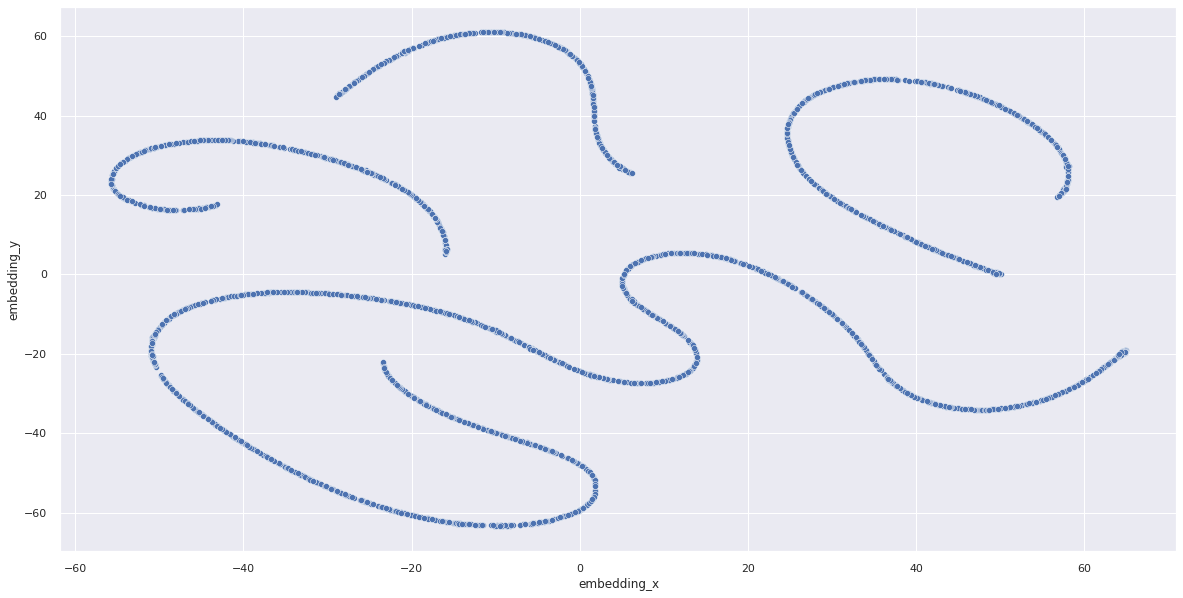

In [128]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform( X )

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

### Tree-Based Embedding

In [129]:
from sklearn import ensemble as en

In [130]:
#training
X = df43.drop( columns=['customer_id', 'gross_revenue'], axis=1)
y = df43['gross_revenue']

#model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42)

#model training
rf_model.fit(X, y)

#leaf

RandomForestRegressor(random_state=42)

In [131]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

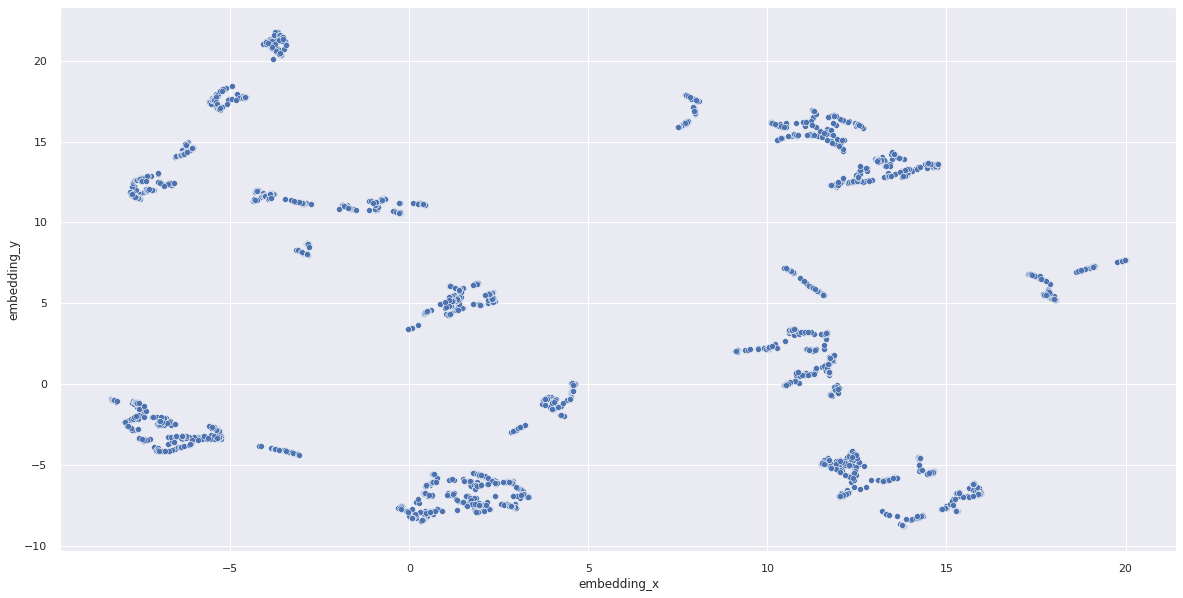

In [132]:
reducer = umap.UMAP( random_state=42)
embedding = reducer.fit_transform( df_leaf )

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree)

# Data Preparation

1. Distribuição normal e não possuí outlier -> Standar Scaler - Média e Desvio Padrão
2. Distribuição normal e possui outlier -> Robust Scaler - Quartis
3. Não é uma distribuição Normal -> Min Max Scaler

Padronização( Standardization ) -> os dados vierem de uma distribuição normal

Rescala     ( Rescale )         -> não tem distribuição normal


**Como saber se é uma distribuição normal?**

1. QQ Plot - Quantile Quantile Plot ( Quatile teorica x Quantile real )
2. KS Teste - Kolgomorov ( Teste de Hipótese ) Se p-value > 0.5 -> Distribuição Normal, p-value < 0.5 -> Não é distribuição normal


In [133]:
#df5 = df4.copy()
df5 = df_tree.copy()

In [134]:
#mm = pp.MinMaxScaler()
#ss = pp.StandardScaler()
#rr = pp.RobustScaler()
#
#
#df5['gross_revenue']          = mm.fit_transform( df5[['gross_revenue']])
#df5['recency_days']           = mm.fit_transform( df5[['recency_days']])
##df5['qtde_invoices']          = mm.fit_transform( df5[['qtde_invoices']])
##df5['qtde_items']             = mm.fit_transform( df5[['qtde_items']])
#df5['qtde_products']          = mm.fit_transform( df5[['qtde_products']])
##df5['avg_ticket']             = mm.fit_transform( df5[['avg_ticket']])
##df5['avg_recency_days']       = mm.fit_transform( df5[['avg_recency_days']])
#df5['frequency']              = mm.fit_transform( df5[['frequency']])
#df5['qtde_returns']           = mm.fit_transform( df5[['qtde_returns']])
##df5['avg_basket_size']        = mm.fit_transform( df5[['avg_basket_size']])
##df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']])

## Teste

In [135]:
#variable = 'gross_revenue'

In [136]:
#Dados AS IS
#print('Min:{} - Max:{}'.format( df5_aux[variable].min(), df5_aux[variable].max()))
#sns.distplot( df5_aux[variable]);

In [137]:
#Dados Normalizados/Rescalados
#print('Min:{} - Max:{}'.format( df5[variable].min(), df5[variable].max()))
#sns.distplot( df5[variable]);

In [138]:
#BoxPlot
#sns.boxplot(df5_aux[variable]);

# Feature Selection

In [139]:
#cols_select = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']

In [140]:
df6 = df5.copy()

# Hyperparameter Fine-Tunning

In [141]:
#X = df6.drop(columns=['customer_id'])
X = df6.copy()

In [142]:
X.head()

,embedding_x,embedding_y
0,11.992380,15.063401
1,17.543764,6.643464
2,12.273921,16.269987
3,1.797640,4.931396
4,-6.984493,12.525932


In [143]:
X.shape

(2968, 2)

## K-Means

In [144]:
from sklearn import metrics as m

In [145]:
clusters = np.arange(2, 30, 1)

In [146]:
x=0
kmeans_list=[]
for k in clusters:
    #model definition
    kmeans_model = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=300)

    #model training
    kmeans_model.fit( X )

    #model predict
    labels = kmeans_model.predict( X )

    #model perfomance
    sil = m.silhouette_score( X, labels, metric='euclidean')
    kmeans_list.append(sil)
    


Text(0, 0.5, 'Silhouette Score')

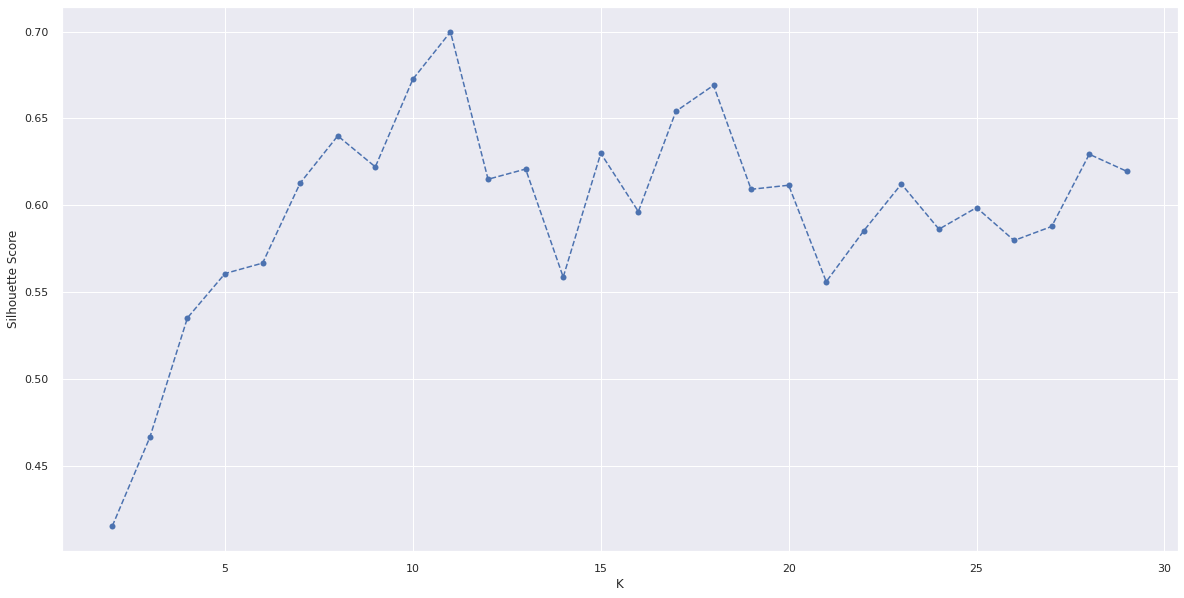

In [147]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

## GMM 

In [148]:
from sklearn import mixture as mx

In [149]:
gmm_list = []
for k in clusters:
    #model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    #model training
    gmm_model.fit(X)
    
    #model predict
    labels = gmm_model.predict( X )

    #model perfomance
    sil = m.silhouette_score( X, labels, metric='euclidean')
    gmm_list.append( sil )

Text(0, 0.5, 'Silhouette Score')

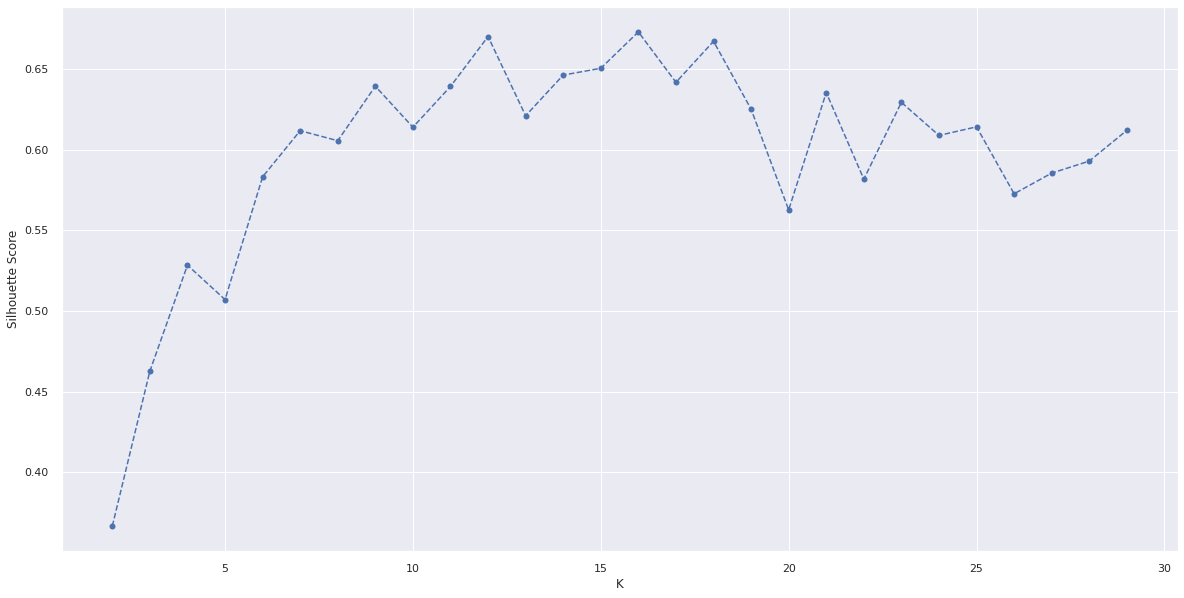

In [150]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

## Hierarchical Clustering 

In [151]:
from scipy.cluster import hierarchy as hc

In [152]:
hc_model = hc.linkage( X, 'ward')

In [153]:
#hc.dendrogram(
#    hc_model,
#    leaf_rotation=90,
#    leaf_font_size=8)
#
#plt.plot()

In [154]:
#hc.dendrogram(
#    hc_model,
#    truncate_mode='lastp',
#    p=12,
#    leaf_rotation=90,
#    leaf_font_size=8,
#    show_contracted=True)
#
#plt.show()

## HClustering Sillhouette Score

In [155]:
hc_list = []
for k in clusters:
    #model definition & training
    hc_model = hc.linkage( X, 'ward')

    #model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    #metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append(sil)

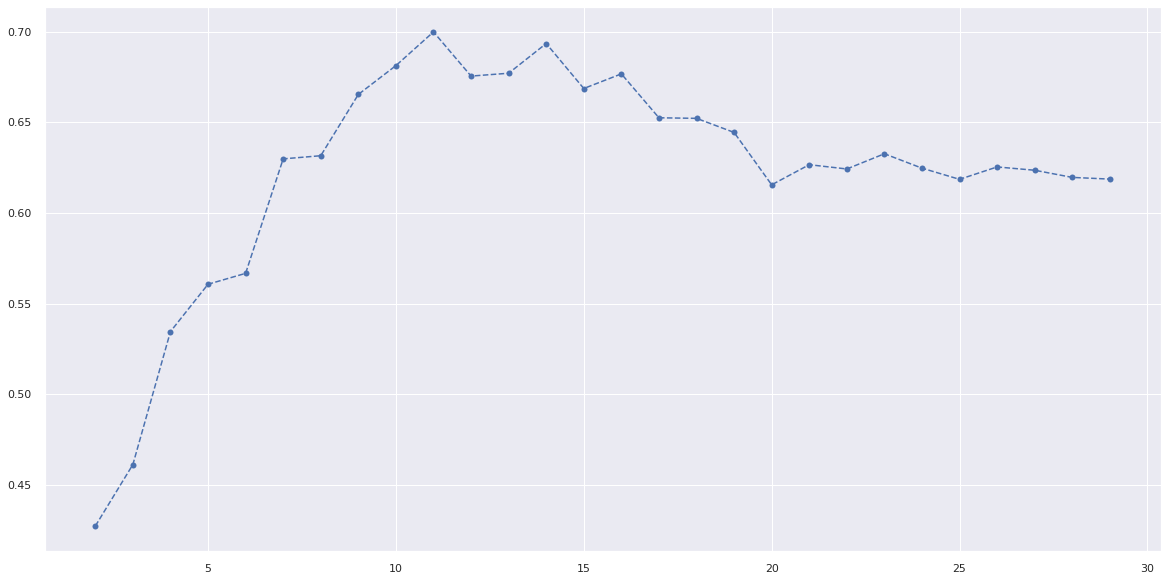

In [156]:
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b')

## DBSCAN 

In [ ]:
eps=2
min_samples=20

#model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples)

#model training
labels = dbscan_model.fit_predict( X )

#metrics
sil = m.silhouette_score( X, labels, metric='euclidean')
print('Silhouette Score: {}'.format( sil ))
print( 'Number of Clusters: {}'.format(len(unique(labels))))

In [ ]:
unique( labels ) #k=2 -1=ruido

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neighbors = NearestNeighbors( n_neighbors = min_samples).fit( X )
distances, indices = neighbors.kneighbors( X )

In [ ]:
distances = np.sort( distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

In [ ]:
plt.plot(distances[2000:])

In [ ]:
dbscan_list = [0.618112, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## Results 

In [157]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
      'GMM': gmm_list,
        'HC': hc_list,
        #'DBSCAN': dbscan_list
    }).T

df_results.columns = clusters

In [158]:
df_results.style.highlight_max( color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
KMeans,0.415151,0.466343,0.535129,0.560660,0.566666,0.612782,0.639972,0.622100,0.672664,0.699859,0.614973,0.620858,0.558604,0.629930,0.596374,0.654134,0.669086,0.609182,0.611527,0.555988,0.585310,0.612228,0.586206,0.598637,0.579689,0.587775,0.629387,0.619526
GMM,0.366483,0.462674,0.528409,0.507038,0.583197,0.611843,0.605619,0.639438,0.614005,0.639276,0.670266,0.621131,0.646351,0.650569,0.673138,0.641837,0.667306,0.625198,0.562712,0.635494,0.581763,0.629427,0.608902,0.614231,0.572696,0.585528,0.592973,0.612064
HC,0.427246,0.461204,0.534550,0.560660,0.566666,0.629827,0.631557,0.665367,0.681264,0.699859,0.675493,0.677059,0.693456,0.668640,0.676708,0.652493,0.652172,0.644414,0.615503,0.626611,0.624250,0.632633,0.624693,0.618534,0.625369,0.623546,0.619603,0.618657


##  Within-Cluster Sum of Square (Wss)

Text(0.5, 1.0, 'WSS vs K')

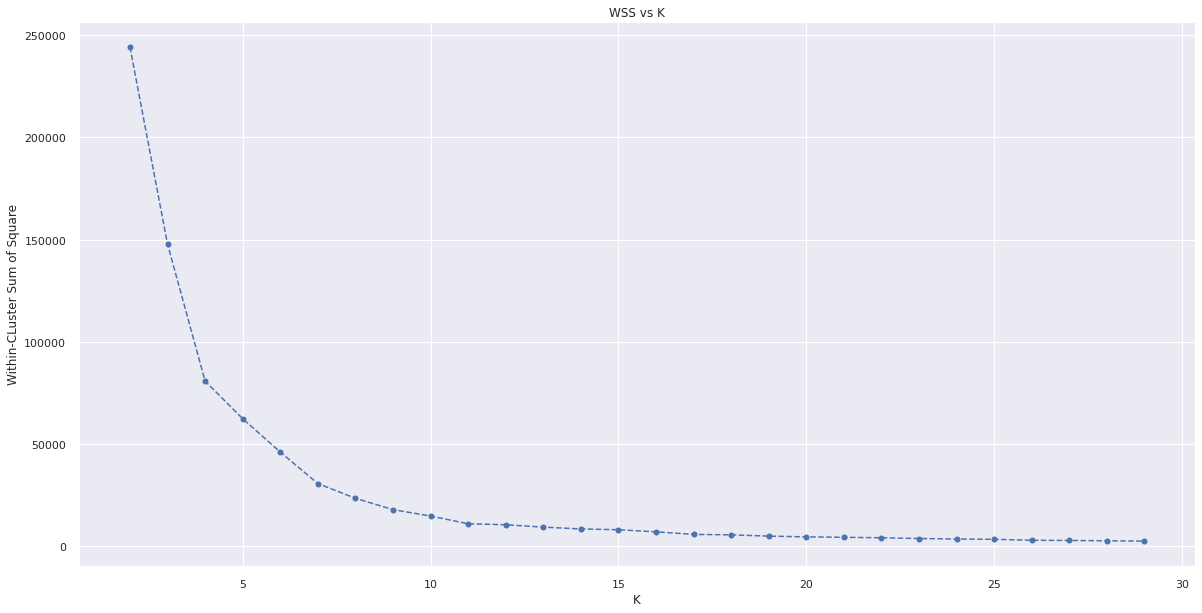

In [159]:
wss = []
for k in clusters:
    #model definition
    kmeans = c.KMeans( init='random', n_clusters = k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit( X )
    
    #validation
    wss.append(kmeans.inertia_)
    
#plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-CLuster Sum of Square')
plt.title('WSS vs K')

## Sillhouette Analysis

In [160]:
#fig, ax = plt.subplots(3, 2 )
#fig.set_size_inches( 25, 20 )
#
#for k in clusters:
#    q, mod = divmod( k, 2)
#    
#    ax[q-1, mod]. set_xlim( [-0.1, 1] )
#    ax[q-1, mod]. set_ylim( [ 0, len(X) + (k+1)*10] )
#    
#    #model definition & training
#    hc_model = hc.linkage( X, 'ward')
#
#    #model predict
#    labels = hc.fcluster( hc_model, k, criterion='maxclust')
#
#    #performance
#    ss = m.silhouette_score(X, labels, metric='euclidean')
#    print('For K = {}. Silhouette Score:{}'.format(k, ss))
#
#    samples_silhouette_values = m.silhouette_samples( X, labels)
#
#
#
#    y_lower = 10
#    for i in range ( k ):
#
#
#        #select clusters
#        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
#        
#        #sort values
#        ith_samples_silhouette_values.sort()        
#
#        #size clusters
#        size_cluster_i = ith_samples_silhouette_values.shape[0]
#        
#
#        #limits
#        y_upper = y_lower + size_cluster_i
#        cmap = cm.get_cmap('Spectral')
#        color = cmap( i/ k )
#
#        ax[q-1, mod].fill_betweenx( np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
#        y_lower = y_upper + 10
#    
#    ax[q-1, mod].set_yticks([])
#    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Model Training

## K-Means

In [199]:
#model definition
k = 11
kmeans = c.KMeans(init ='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## HClustering Sillhouette Score

In [185]:
k = 11
#model definition & training
hc_model = hc.linkage( X, 'ward')

#model predict
labels = hc.fcluster( hc_model, k, criterion='maxclust' )

## GMM

In [182]:
k=12
#model definition
gmm_model = mx.GaussianMixture( n_components=k )

#model training
gmm_model.fit(X)

#model predict
labels = gmm_model.predict( X )

## Cluster Validation

In [196]:
#WSS (Within-cluster sum of square)
print('WSS value: {}'.format( kmeans.inertia_ ) )

# SS (Silhouette Score)
print('SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) ) 

WSS value: 14821.287109375
SS value: 0.6412756443023682


# Cluster Analysis

In [200]:
df9 = X.copy()
df9['clusters'] = labels
df9.head()

,embedding_x,embedding_y,clusters
0,11.992380,15.063401,10
1,17.543764,6.643464,9
2,12.273921,16.269987,10
3,1.797640,4.931396,0
4,-6.984493,12.525932,7


## Vizualization Inspection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

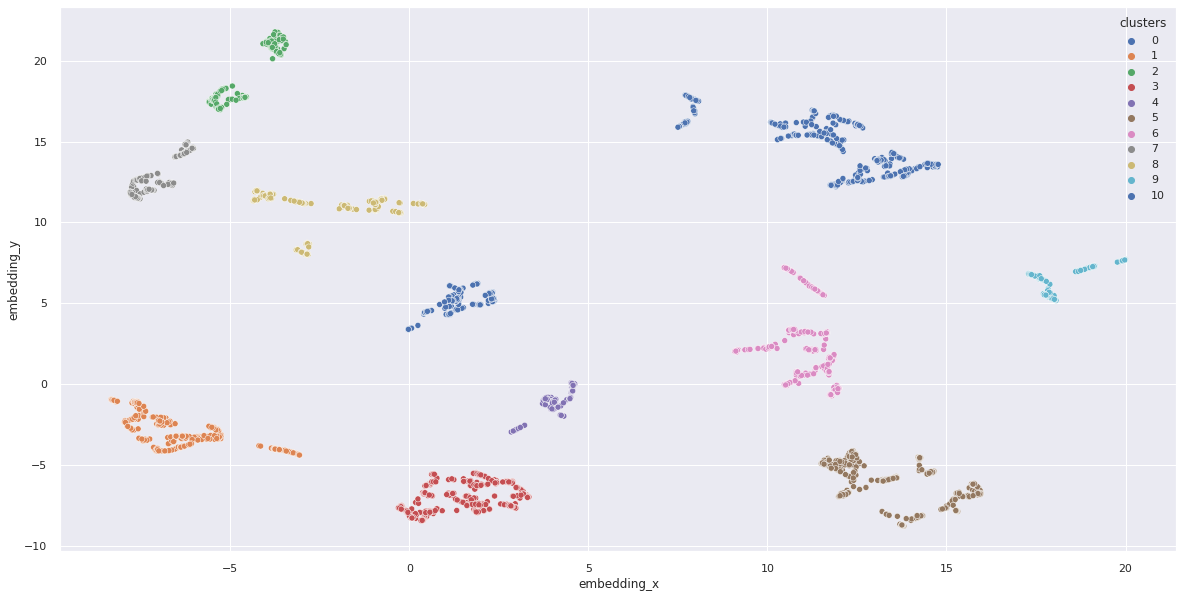

In [201]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='clusters', data=df9, palette='deep')

In [167]:
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='clusters')
#fig.show()

#visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick')
#visualizer.fit( X )
#visualizer.finalize()

## 2d Plot

In [168]:
#df_viz = df9.drop( columns='customer_id', axis=1)
#sns.pairplot( df_viz, hue='clusters')

## UMAP

Machine Learning - Mainfold
PCA - Matrix, Espaço de Distância - Espaço de Hilbert -  9 condições - Colorários

UMAP - t-SNE (2009) - Mainfold - Topologia

In [169]:
#reducer = umap.UMAP( n_neighbors=20, random_state=42)
#embedding = reducer.fit_transform( X )
#
##embedding
#df_viz['embedding_x'] = embedding[:, 0]
#df_viz['embedding_y'] = embedding[:, 1]
#
##plot UMAP
#sns.scatterplot(x='embedding_x', y='embedding_y', hue='clusters', 
#                palette=sns.color_palette('hls', n_colors=len(df_viz['clusters'].unique() )), data=df_viz)

## Cluster Profile

In [202]:
df9 = df4.copy()
df9['clusters'] = labels

In [203]:
df9.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,clusters
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,8.735294,10
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,19.000000,9
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,15.466667,10
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000,0
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,1.000000,7


In [204]:
#Number of customer
df_cluster = df9[['customer_id', 'clusters']].groupby('clusters').count().reset_index()
df_cluster['perc_customer'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

#AVG Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='clusters')

#AVG recency days
df_avg_gross_days = df9[['recency_days', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_days, how='inner', on='clusters')

#AVG invoice_no
df_avg_invoice_no = df9[['qtde_products', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='clusters')

#AVG ticket
df_ticket = df9[['frequency', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='clusters')

#AVG ticket
df_ticket = df9[['qtde_returns', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='clusters')

In [205]:
df_cluster
#gross_revenue = média de gastos
#recency_days = a cada X dias as pessoas estão fazendo compra
#invoice_no = compra em média X produtos


,clusters,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0,175,5.896226,827.409714,92.022857,26.811429,0.161952,22.868571
1,1,322,10.849057,971.000590,75.329193,37.456522,0.074586,6.571429
2,2,200,6.738544,647.933500,47.280000,11.510000,0.025991,0.845000
3,3,372,12.533693,1237.710134,61.282258,54.346774,0.043705,8.771505
4,4,134,4.514825,4595.674627,52.194030,101.134328,0.063555,39.432836
5,5,404,13.611860,1689.073490,54.809406,89.175743,0.049992,11.542079
6,6,356,11.994609,2404.790843,43.603933,128.362360,0.042313,19.904494
7,7,166,5.592992,424.504277,162.271084,11.198795,0.743519,18.361446
8,8,226,7.614555,565.176947,139.991150,18.681416,0.193812,2.893805
9,9,145,4.885445,3164.115448,34.427586,173.841379,0.060415,23.482759


### Cluster 01: (Candidato a Insider)

- Número de customers: 6 (0.14% do customers)
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00 dólares

### Cluster 02:

- Número de customers: 31 (0.71% do customers)
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

### Cluster 03:

- Número de customers: 4335 (99,15% do customers)
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1372,5 dólares